In [2]:
% config InlineBackend.figure_formats =['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

UsageError: Line magic function `%` not found.


```{autolink-concat}
```

````{margin}
```{spec} Amplitude analysis with zfit
:id: TR-020
:status: WIP
:tags: physics;sympy;tensorwaves

This reports builds a [simple symbolic amplitude model](https://tensorwaves.readthedocs.io/en/0.4.5/amplitude-analysis.html) with {mod}`qrules` and {mod}`ampform` and feeds it to [zfit](https://zfit.rtfd.io) instead of {mod}`tensorwaves`. See {issue}`ComPWA/compwa-org#156`.
```
````

# Amplitude analysis with zfit

In [2]:
% pip install -q ampform~=0.14.1 pandas~=1.4.2 sympy~=1.10.1 tensorwaves[jax, pwa]~=0.4.8 zfit~=0.10.0 hepstats~=0.6.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
import logging
import os
import warnings

JAX_LOGGER = logging.getLogger("absl")
JAX_LOGGER.setLevel(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore")

## Formulating the model

In [4]:
import qrules

reaction = qrules.generate_transitions(
    initial_state=("J/psi(1S)", [-1, +1]),
    final_state=["gamma", "pi0", "pi0"],
    allowed_intermediate_particles=["f(0)"],
    allowed_interaction_types=["strong", "EM"],
    formalism="helicity",
)

Propagating quantum numbers:   0%|          | 0/16 [00:00<?, ?it/s]

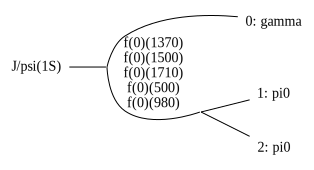

In [5]:
import graphviz

dot = qrules.io.asdot(reaction, collapse_graphs=True)
graphviz.Source(dot)

In [6]:
import ampform
from ampform.dynamics.builder import (
    create_non_dynamic_with_ff,
    create_relativistic_breit_wigner_with_ff,
)

model_builder = ampform.get_builder(reaction)
model_builder.scalar_initial_state_mass = True
model_builder.stable_final_state_ids = [0, 1, 2]
model_builder.set_dynamics("J/psi(1S)", create_non_dynamic_with_ff)
for name in reaction.get_intermediate_particles().names:
    model_builder.set_dynamics(name, create_relativistic_breit_wigner_with_ff)
model = model_builder.formulate()

## Generate data

### Phase space sample

In [7]:
from tensorwaves.data import TFPhaseSpaceGenerator, TFUniformRealNumberGenerator

rng = TFUniformRealNumberGenerator(seed=0)
phsp_generator = TFPhaseSpaceGenerator(
    initial_state_mass=reaction.initial_state[-1].mass,
    final_state_masses={i: p.mass for i, p in reaction.final_state.items()},
)
phsp_momenta = phsp_generator.generate(100_000, rng)

2022-09-03 15:33:56.850292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 15:33:56.850585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-03 15:33:56.850636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-03 15:33:56.850683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-03 15:33:56.850731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Generating phase space sample:   0%|          | 0/100000 [00:00<?, ?it/s]

2022-09-03 15:33:57.936486: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7fc0240d0cc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-03 15:33:57.936535: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-09-03 15:33:57.940500: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-09-03 15:33:57.954623: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
import numpy as np
import pandas as pd

pd.DataFrame(
    {
        (k, label): np.transpose(v)[i]
        for k, v in phsp_momenta.items()
        for i, label in enumerate(["E", "px", "py", "pz"])
    }
)

p0                                      p1                      \
              E        px        py        pz         E        px        py   
0      0.811317  0.787621  0.144327  0.130609  1.092959 -0.019148 -0.531113   
1      0.602303 -0.343019 -0.367933  0.331259  1.431153  1.173457 -0.078558   
2      1.165704  0.115778  0.666757 -0.949155  1.443427  0.192011 -0.593016   
3      0.593783  0.392870  0.407210 -0.180034  1.246726  0.037716  0.106090   
4      0.864272 -0.668511  0.516082  0.183623  0.754404 -0.716281 -0.135528   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.472639  0.250787  0.395665  0.062791  1.126885  0.041148  0.795625   
99996  1.330392  1.185399  0.538998 -0.272492  0.419241 -0.033333  0.139318   
99997  0.864709  0.258491  0.294117 -0.770973  1.444051 -0.804658  0.065531   
99998  0.607279  0.563725  0.219317 -0.053868  0.968601  0.899961  0.061514   
99999  1.148659 -0.481566  0.715177  0.758969  1.291588  0.469209 -1.158960   

                       p2                                
             pz         E        px        py        pz  
0     -0.945459  1.192624 -0.768473  0.386786  0.814849  
1     -0.804244  1.063444 -0.830437  0.446491  0.472984  
2      1.294884  0.487770 -0.307789 -0.073741 -0.345729  
3      1.234273  1.256391 -0.430586 -0.513300 -1.054238  
4      0.139574  1.478224  1.384792 -0.380554 -0.323197  
...         ...       ...       ...       ...       ...  
99995  0.785454  1.497377 -0.291935 -1.191290 -0.848245  
99996  0.370167  1.347267 -1.152066 -0.678316 -0.097675  
99997  1.189662  0.788140  0.546167 -0.359648 -0.418689  
99998  0.325968  1.521020 -1.463686 -0.280831 -0.272100  
99999 -0.294342  0.656653  0.012357  0.443783 -0.464627  

[100000 rows x 12 columns]

### Intensity-based sample

In [9]:
from tensorwaves.function.sympy import create_function

unfolded_expression = model.expression.doit()
fixed_intensity_func = create_function(
    unfolded_expression.xreplace(model.parameter_defaults),
    backend="jax",
)

In [10]:
from tensorwaves.data import SympyDataTransformer

transform_momenta = SympyDataTransformer.from_sympy(
    model.kinematic_variables, backend="jax"
)

In [11]:
from tensorwaves.data import (
    IntensityDistributionGenerator,
    TFWeightedPhaseSpaceGenerator,
)

weighted_phsp_generator = TFWeightedPhaseSpaceGenerator(
    initial_state_mass=reaction.initial_state[-1].mass,
    final_state_masses={i: p.mass for i, p in reaction.final_state.items()},
)
data_generator = IntensityDistributionGenerator(
    domain_generator=weighted_phsp_generator,
    function=fixed_intensity_func,
    domain_transformer=transform_momenta,
)
data_momenta = data_generator.generate(10_000, rng)

Generating intensity-based sample:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
phsp = transform_momenta(phsp_momenta)
data = transform_momenta(data_momenta)
pd.DataFrame(data)

,m_12,phi_0,phi_1^12,theta_0,theta_1^12
0,1.499845+0.000000j,2.941350,-0.984419,2.344617,1.064114
1,0.580070+0.000000j,1.422127,0.183725,1.086667,1.535691
2,1.495937+0.000000j,2.695585,3.063622,0.777978,1.730394
3,1.172263+0.000000j,0.527850,1.515685,1.343530,0.602596
4,1.581282+0.000000j,-0.678981,-2.951556,2.987470,1.959462
...,...,...,...,...,...
9995,1.486016+0.000000j,-1.271331,-1.387495,2.792571,2.565453
9996,0.584599+0.000000j,-2.452912,-1.957086,1.070889,2.313677
9997,1.956302+0.000000j,0.378314,2.711496,0.588987,1.551541
9998,1.585024+0.000000j,-0.816920,-1.166315,2.076068,1.807813


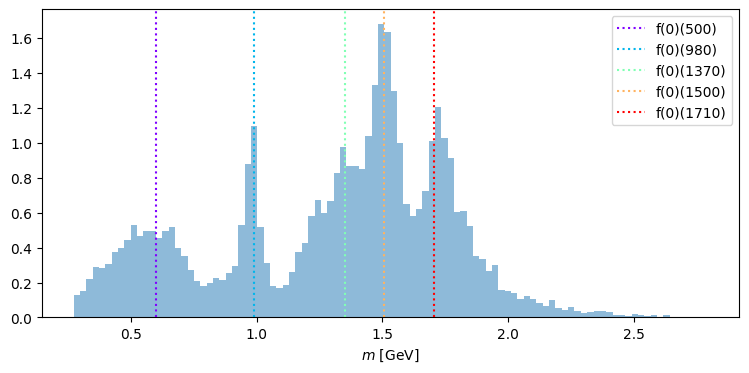

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm

resonances = sorted(
    reaction.get_intermediate_particles(),
    key=lambda p: p.mass,
)
evenly_spaced_interval = np.linspace(0, 1, len(resonances))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(
    np.real(data["m_12"]),
    bins=100,
    alpha=0.5,
    density=True,
)
ax.set_xlabel("$m$ [GeV]")
for p, color in zip(resonances, colors):
    ax.axvline(x=p.mass, linestyle="dotted", label=p.name, color=color)
ax.legend()
plt.show()

## Fit

### Determine free parameters

In [14]:
initial_parameters = {
    R"C_{J/\psi(1S) \to {f_{0}(1500)}_{0} \gamma_{+1}; f_{0}(1500) \to \pi^{0}_{0} \pi^{0}_{0}}": 1.0
                                                                                                  + 0.0j,
    "m_{f_{0}(500)}": 0.4,
    "m_{f_{0}(980)}": 0.88,
    "m_{f_{0}(1370)}": 1.22,
    "m_{f_{0}(1500)}": 1.45,
    "m_{f_{0}(1710)}": 1.83,
    R"\Gamma_{f_{0}(500)}": 0.3,
    R"\Gamma_{f_{0}(980)}": 0.1,
    R"\Gamma_{f_{0}(1710)}": 0.3,
}

### Parametrized function and caching

In [15]:
from tensorwaves.function.sympy import create_parametrized_function

intensity_func = create_parametrized_function(
    expression=unfolded_expression,
    parameters=model.parameter_defaults,
    backend="jax",
)

In [16]:
from tensorwaves.estimator import create_cached_function

free_parameter_symbols = [
    symbol
    for symbol in model.parameter_defaults
    if symbol.name in set(initial_parameters)
]
cached_intensity_func, transform_to_cache = create_cached_function(
    unfolded_expression,
    parameters=model.parameter_defaults,
    free_parameters=free_parameter_symbols,
    backend="jax",
)
cached_data = transform_to_cache(data)
cached_phsp = transform_to_cache(phsp)

### Estimator

In [17]:
from tensorwaves.estimator import UnbinnedNLL

estimator = UnbinnedNLL(
    intensity_func,
    data=data,
    phsp=phsp,
    backend="jax",
)
estimator_with_caching = UnbinnedNLL(
    cached_intensity_func,
    data=cached_data,
    phsp=cached_phsp,
    backend="jax",
)

### Optimize fit parameters

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

reaction_info = model.reaction_info
resonances = sorted(
    reaction_info.get_intermediate_particles(),
    key=lambda p: p.mass,
)

evenly_spaced_interval = np.linspace(0, 1, len(resonances))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]


def indicate_masses(ax):
    ax.set_xlabel("$m$ [GeV]")
    for color, resonance in zip(colors, resonances):
        ax.axvline(
            x=resonance.mass,
            linestyle="dotted",
            label=resonance.name,
            color=color,
        )


def compare_model(
    variable_name,
    data,
    phsp,
    function,
    bins=100,
):
    intensities = function(phsp)
    _, ax = plt.subplots(figsize=(9, 4))
    data_projection = np.real(data[variable_name])
    ax = plt.gca()
    ax.hist(
        data_projection,
        bins=bins,
        alpha=0.5,
        label="data",
        density=True,
    )
    phsp_projection = np.real(phsp[variable_name])
    ax.hist(
        phsp_projection,
        weights=np.array(intensities),
        bins=bins,
        histtype="step",
        color="red",
        label="fit model",
        density=True,
    )
    indicate_masses(ax)
    ax.legend()

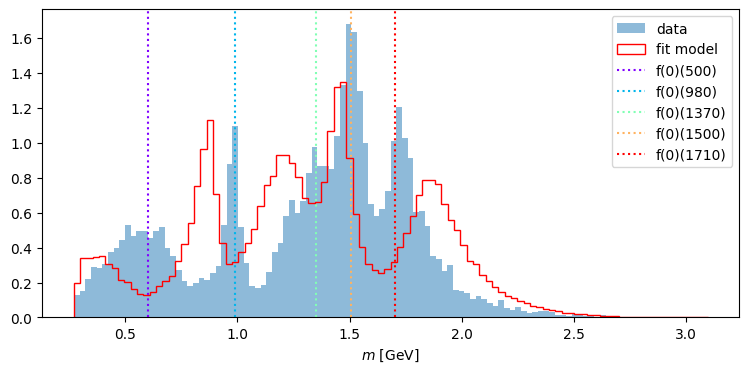

In [19]:
original_parameters = intensity_func.parameters
intensity_func.update_parameters(initial_parameters)
compare_model("m_12", data, phsp, intensity_func)

In [20]:
from tensorwaves.optimizer import Minuit2
from tensorwaves.optimizer.callbacks import CSVSummary

minuit2 = Minuit2(
    callback=CSVSummary("fit_traceback.csv"),
    use_analytic_gradient=False,
)
fit_result = minuit2.optimize(estimator, initial_parameters)
fit_result

0it [00:00, ?it/s]

FitResult(
 minimum_valid=True,
 execution_time=6.390016078948975,
 function_calls=539,
 estimator_value=-4891.017307548102,
 parameter_values={
  'm_{f_{0}(500)}': 0.6102707294730896,
  'm_{f_{0}(980)}': 0.9902119846617343,
  'm_{f_{0}(1370)}': 1.3456300421935787,
  'm_{f_{0}(1500)}': 1.5050299510026404,
  'm_{f_{0}(1710)}': 1.7096496843688758,
  '\\Gamma_{f_{0}(500)}': 0.4226040807761186,
  '\\Gamma_{f_{0}(980)}': 0.0647933950777472,
  '\\Gamma_{f_{0}(1710)}': 0.13301019075452047,
  'C_{J/\\psi(1S) \\to {f_{0}(1500)}_{0} \\gamma_{+1}; f_{0}(1500) \\to \\pi^{0}_{0} \\pi^{0}_{0}}': (1.0699249014537464-0.018664035531896654j),
 },
 parameter_errors={
  'm_{f_{0}(500)}': 0.006168655462429218,
  'm_{f_{0}(980)}': 0.0016283609777853153,
  'm_{f_{0}(1370)}': 0.0051225884206156595,
  'm_{f_{0}(1500)}': 0.0033157863189151415,
  'm_{f_{0}(1710)}': 0.0025660827302696762,
  '\\Gamma_{f_{0}(500)}': 0.02383818638273316,
  '\\Gamma_{f_{0}(980)}': 0.0035566730133893385,
  '\\Gamma_{f_{0}(1710)}': 0.0

In [21]:
minuit2 = Minuit2()
fit_result_with_caching = minuit2.optimize(
    estimator_with_caching, initial_parameters
)
fit_result_with_caching

0it [00:00, ?it/s]

FitResult(
 minimum_valid=True,
 execution_time=3.885925769805908,
 function_calls=539,
 estimator_value=-4891.017307548096,
 parameter_values={
  'm_{f_{0}(500)}': 0.6102707294726573,
  'm_{f_{0}(980)}': 0.9902119846619376,
  'm_{f_{0}(1370)}': 1.3456300421930578,
  'm_{f_{0}(1500)}': 1.5050299510027396,
  'm_{f_{0}(1710)}': 1.7096496843687876,
  '\\Gamma_{f_{0}(500)}': 0.4226040807791028,
  '\\Gamma_{f_{0}(980)}': 0.06479339507798289,
  '\\Gamma_{f_{0}(1710)}': 0.13301019075489123,
  'C_{J/\\psi(1S) \\to {f_{0}(1500)}_{0} \\gamma_{+1}; f_{0}(1500) \\to \\pi^{0}_{0} \\pi^{0}_{0}}': (1.0699249014639738-0.01866403552364957j),
 },
 parameter_errors={
  'm_{f_{0}(500)}': 0.006168655468601833,
  'm_{f_{0}(980)}': 0.0016283609764478283,
  'm_{f_{0}(1370)}': 0.005122588418418837,
  'm_{f_{0}(1500)}': 0.003315786312405824,
  'm_{f_{0}(1710)}': 0.0025660827282890887,
  '\\Gamma_{f_{0}(500)}': 0.023838186423986687,
  '\\Gamma_{f_{0}(980)}': 0.003556673014228813,
  '\\Gamma_{f_{0}(1710)}': 0.007

### Fit result analysis

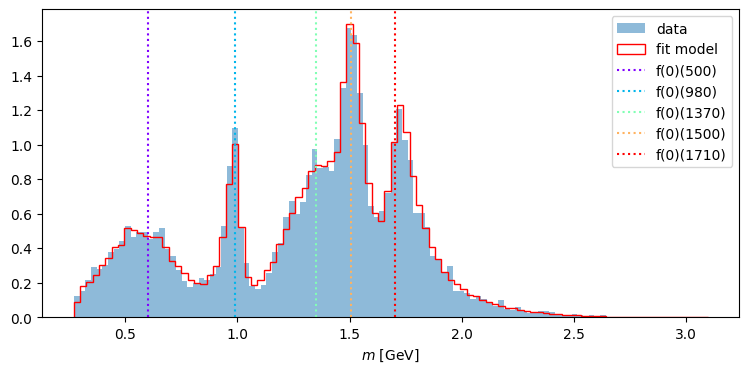

In [22]:
intensity_func.update_parameters(fit_result.parameter_values)
compare_model("m_12", data, phsp, intensity_func)

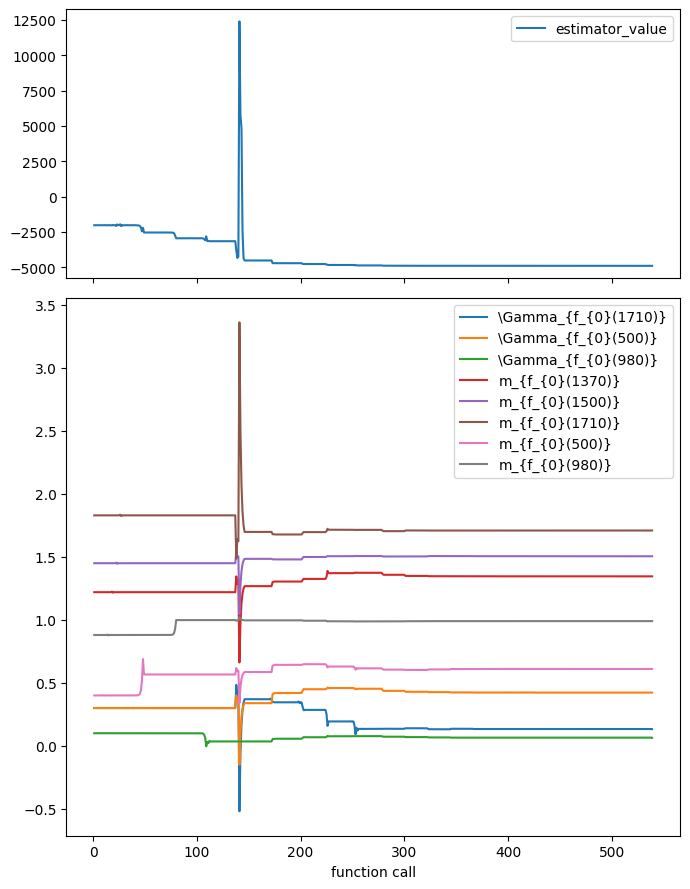

In [23]:
fit_traceback = pd.read_csv("fit_traceback.csv")
fig, (ax1, ax2) = plt.subplots(
    2, figsize=(7, 9), sharex=True, gridspec_kw={"height_ratios": [1, 2]}
)
fit_traceback.plot("function_call", "estimator_value", ax=ax1)
fit_traceback.plot("function_call", sorted(initial_parameters), ax=ax2)
fig.tight_layout()
ax2.set_xlabel("function call");

## Zfit

### PDF definition

In [24]:
import zfit  # suppress tf warnings
from zfit import z
import zfit.z.numpy as znp
from zfit import supports

zfit.run.set_graph_mode(False)  # We cannot (yet) compile through the function
zfit.run.set_autograd_mode(False)


class TensorWavesPDF(zfit.pdf.BasePDF):
    def __init__(self, intensity, norm, obs, params=None, name="tensorwaves"):
        """tensorwaves intensity normalized over the *norm* dataset."""
        super().__init__(obs, params, name)
        self.intensity = intensity
        norm = {ob: jnp.asarray(ar) for ob, ar in zip(self.obs, z.unstack_x(norm))}
        self.norm_sample = norm

    @supports(norm=True)
    def _pdf(
        self, x, norm
    ):  # we can also use better mechanics, where it automatically normalizes or not
        # this here is rather to take full control, it is always possible

        # updating the parameters of the model. This seems not very TF compatible?
        self.intensity.update_parameters(
            {p.name: float(p) for p in self.params.values()}
        )

        # converting the data to a dict for tensorwaves
        data = {ob: jnp.asarray(ar) for ob, ar in zip(self.obs, z.unstack_x(x))}

        non_normalized_pdf = self.intensity(data)
        # this is not really needed, but can be useful for e.g. sampling with `pdf(..., norm_range=False)`
        if norm is False:
            out = non_normalized_pdf
        else:
            out = non_normalized_pdf / jnp.mean(self.intensity(self.norm_sample))
        return znp.asarray(out)

In [25]:
params = [
    zfit.param.convert_to_parameter(val, name, prefer_constant=False)
    for name, val in model.parameter_defaults.items()
]

In [26]:
def reset_parameters():
    for p in params_fit:
        if p.name in initial_parameters:
            p.set_value(initial_parameters[p.name])

In [27]:
obs = [
    zfit.Space(ob, limits=(np.min(data[ob]) - 1, np.max(data[ob]) + 1))
    for ob in pd.DataFrame(phsp)
]
obs_all = zfit.dimension.combine_spaces(*obs)

### Data conversion

In [28]:
phsp_zfit = zfit.Data.from_pandas(pd.DataFrame(phsp), obs=obs_all)
data_zfit = zfit.Data.from_pandas(pd.DataFrame(data), obs=obs_all)

### Perform fit

In [29]:
params_fit = [
    p for p in params if p.name in initial_parameters if p.independent
]  # remove the complex parameters

In [30]:
jax_intensity_func = create_parametrized_function(
    expression=unfolded_expression,
    parameters=model.parameter_defaults,
    backend="jax",
)

In [31]:
reset_parameters()

In [32]:
pdf = TensorWavesPDF(
    obs=obs_all,
    intensity=jax_intensity_func,
    norm=phsp_zfit,
    params={f"{p.name}": p for i, p in enumerate(params_fit)},
)
loss = zfit.loss.UnbinnedNLL(pdf, data_zfit)

In [33]:
minimizer = zfit.minimize.Minuit(gradient=True, mode=0)

In [34]:
# minimizer = zfit.minimize.ScipyTrustConstrV1()  # we could try different minimizers, but Minuit seems to perform best

In [40]:
%%time
result = minimizer.minimize(loss)
result

CPU times: user 18.2 s, sys: 135 ms, total: 18.3 s
Wall time: 6.97 s


FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.TensorWavesPDF'>  params=[\Gamma_{f_{0}(1710)}, \Gamma_{f_{0}(500)}, \Gamma_{f_{0}(980)}, m_{f_{0}(1370)}, m_{f_{0}(1500)}, m_{f_{0}(1710)}, m_{f_{0}(500)}, m_{f_{0}(980)}]] data=[<zfit.core.data.Data object at 0x7fbfec4ec8e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00041 │ -1871.035   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                    value  (rounded)    at limit
--------------------  ------------------  ----------
m_{f_{0}(500)}                  0.608864       False
\Gamma_{f_{0}(500)}             0.419716       False
m_{f_{0}(980)}                  0.990038       False
\Gamma_{f_{0}(980)}            0.0643328     

In [41]:
%%time
result.hesse(name="hesse")
result

CPU times: user 1.99 s, sys: 25.8 ms, total: 2.01 s
Wall time: 641 ms


FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.TensorWavesPDF'>  params=[\Gamma_{f_{0}(1710)}, \Gamma_{f_{0}(500)}, \Gamma_{f_{0}(980)}, m_{f_{0}(1370)}, m_{f_{0}(1500)}, m_{f_{0}(1710)}, m_{f_{0}(500)}, m_{f_{0}(980)}]] data=[<zfit.core.data.Data object at 0x7fbfec4ec8e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00041 │ -1871.035   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                    value  (rounded)        hesse    at limit
--------------------  ------------------  -----------  ----------
m_{f_{0}(500)}                  0.608864  +/-  0.0061       False
\Gamma_{f_{0}(500)}             0.419716  +/-   0.024       False
m_{f_{0}(980)}                  0.990038  +/- 

In [42]:
%%time
result.errors(name='errors')
result

CPU times: user 37.9 s, sys: 312 ms, total: 38.2 s
Wall time: 12.6 s


FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.TensorWavesPDF'>  params=[\Gamma_{f_{0}(1710)}, \Gamma_{f_{0}(500)}, \Gamma_{f_{0}(980)}, m_{f_{0}(1370)}, m_{f_{0}(1500)}, m_{f_{0}(1710)}, m_{f_{0}(500)}, m_{f_{0}(980)}]] data=[<zfit.core.data.Data object at 0x7fbfec4ec8e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00041 │ -1871.035   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                    value  (rounded)        hesse               errors    at limit
--------------------  ------------------  -----------  -------------------  ----------
m_{f_{0}(500)}                  0.608864  +/-  0.0061  -  0.006   + 0.0063       False
\Gamma_{f_{0}(500)}             0.419716  +/-   0

### Statistical inference using the hepstats library

 hepstats is built on top of zfit-interface

In [38]:
from hepstats.hypotests import ConfidenceInterval
from hepstats.hypotests.calculators import AsymptoticCalculator, FrequentistCalculator
from hepstats.hypotests.parameters import POIarray

In [43]:
calculator = AsymptoticCalculator(result, minimizer)

In [46]:
# we take one of the parameters as poi
poi = pdf.params[r"\Gamma_{f_{0}(500)}"]
poi

<zfit.Parameter '\Gamma_{f_{0}(500)}' floating=True value=0.4197>

In [47]:
poinull = POIarray(poi, np.linspace(poi - 0.1, poi + 0.1, 50))

In [48]:
ci = ConfidenceInterval(calculator, poinull)

In [50]:
alpha = 0.32
ci.interval(alpha=alpha);


Confidence interval on \Gamma_{f_{0}(500)}:
	0.3960645754671929 < \Gamma_{f_{0}(500)} < 0.44298646456517543 at 68.0% C.L.

Confidence interval on \Gamma_{f_{0}(500)}:
	0.3960645754671929 < \Gamma_{f_{0}(500)} < 0.44298646456517543 at 68.0% C.L.


In [51]:
# helper function to plot the ersult
def one_minus_cl_plot(x, pvalues, alpha=None, ax=None):
    if alpha is None:
        alpha = [0.32]
    if isinstance(alpha, (float, int)):
        alpha = [alpha]
    if ax is None:
        ax = plt.gca()

    ax.plot(x, pvalues, ".--")
    for a in alpha:
        ax.axhline(a, color="red", label="$\\alpha = " + str(a) + "$")
    ax.set_ylabel("1-CL")

    return ax

Text(0.5, 0, '$\\Gamma_{f_{0}(500)}$')

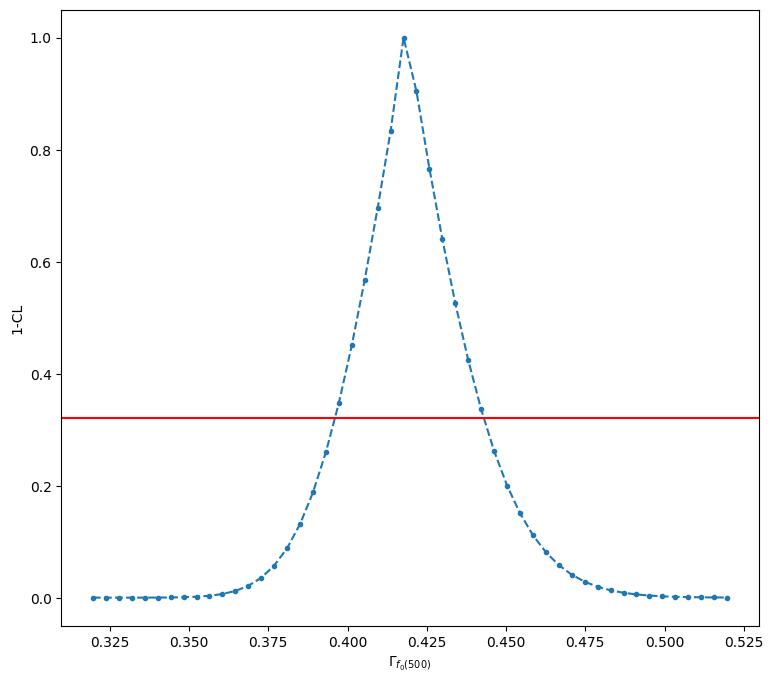

In [52]:
f = plt.figure(figsize=(9, 8))
one_minus_cl_plot(poinull.values, ci.pvalues(), alpha=alpha)
plt.xlabel(f"${poi.name}$")
